In [1]:
import torch
from torch.utils.data import Dataset
import random

class ShapesDataset(Dataset):
    """Dataset of generated binary shape images."""

    def __init__(self, image_size=100, random_invert=True, n_images=1000):
        self.data = self.create_shapes(image_size, random_invert, n_images)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    def create_shapes(self, image_size, random_invert, n_images):
        data = torch.zeros(n_images, image_size, image_size)
        
        for i in range(n_images):
            # choose a shape
            # choose a scale and position
            r1 = int(image_size/2 - 20 + random.random()*6 - 3)
            r2 = int(image_size/2 + 20 + random.random()*6 - 3)
            c1 = int(image_size/2 - 20 + random.random()*6 - 3)
            c2 = int(image_size/2 + 20 + random.random()*6 - 3)
            data[i, r1:r2, c1:c2] = 1
            
            if random_invert and random.random() > 0.5:
                data[i] = 1 - data[i]
        
        return data

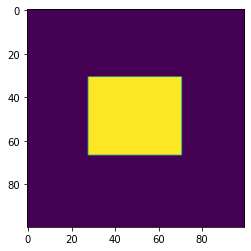

In [2]:
import matplotlib.pyplot as plt

shapes = ShapesDataset()

plt.imshow(shapes[1])

In [3]:
import torch
import torch.nn as nn
from dsketch.raster.disttrans import line_edt2
from dsketch.raster.raster import exp
from dsketch.raster.composite import softor

class AE(nn.Module):
  def __init__(self, nlines=4, hidden=64, sz=100):
    super(AE, self).__init__()

    # build the coordinate grid:
    r = torch.linspace(-1, 1, sz)
    c = torch.linspace(-1, 1, sz)
    grid = torch.meshgrid(r, c)
    self.grid = torch.stack(grid, dim=2)

    # encoder
    self.enc = nn.Sequential(
        nn.Linear(sz**2, hidden),
        nn.ReLU(),
        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Linear(hidden, nlines*4),
        nn.Tanh())

  def forward(self, inp, sigma=1e-4):
    self.grid = self.grid.to(inp.device)
    
    # the encoding process will flatten the input and
    # push it through the encoder network
    bs = inp.shape[0]
    x = inp.view(bs, -1) # [batch,28,28] -> [batch,28*28]
    z = self.enc(x) # -> [batch,5*4]
    z = z.view(bs, -1, 2, 2) # -> [batch, 5, 2, 2]

    # Rasterisation steps
    rasters = exp(line_edt2(z, self.grid), sigma) # -> [batch, 5, 28, 28]

    return softor(rasters)

In [4]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
import torchvision
import numbers
import math

batch_size = 256
loader = torch.utils.data.DataLoader(shapes, batch_size=batch_size, shuffle=True, num_workers=0)

sigma=1e-2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AE(nlines=4).to(device)

opt = torch.optim.Adam(model.parameters())

class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, sigma, kernel_size=None, dim=2):
        super(GaussianSmoothing, self).__init__()
        
        if kernel_size is None:
            kernel_size = 8*sigma + 1
            if kernel_size % 2 == 0:
                kernel_size += 1
        
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        eps = 0.0001
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / ((std + eps) * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (std + eps)) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = nn.functional.conv1d
        elif dim == 2:
            self.conv = nn.functional.conv2d
        elif dim == 3:
            self.conv = nn.functional.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        p = int(self.weight.shape[-1] / 2)
        input = nn.functional.pad(input, (p, p, p, p), mode='reflect')
        return self.conv(input, weight=self.weight, groups=self.groups)


def blurred_mse_loss(input, target, sigma):
    input = input.unsqueeze(1)
    target = target.unsqueeze(1)
    g = GaussianSmoothing(1, sigma).to(input.device)
    ginput = g(input)
#     gtarget = g(target)
    gtarget = target
    
    return nn.functional.mse_loss(ginput, gtarget)

for epoch in range(100):
  for images in loader:
    images = images.to(device)
    opt.zero_grad()
    out = model(images, sigma)
    loss = nn.functional.mse_loss(out, images)
#     loss = blurred_mse_loss(out, images, 0)
    loss.backward()
    opt.step()

#   if sigma > 1e-2:
#     sigma *= 0.95

  print(loss, sigma)

tensor(0.3513, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.3351, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.3186, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.3227, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.3095, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.2891, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.2997, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.2901, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.2552, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.2624, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.2982, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.2468, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.2596, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.2587, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.2692, device='cuda:0', grad_fn=<MseLossBackward>) 0.01
tensor(0.2399, device='cuda:0', grad_fn=

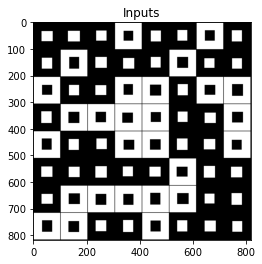

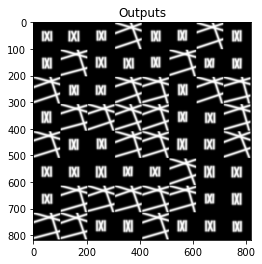

In [5]:
batch = iter(loader).next()[0:64]
out = model(batch.to(device), sigma=sigma)

plt.figure()
inputs = torchvision.utils.make_grid(batch.unsqueeze(1))
plt.title("Inputs")
plt.imshow(inputs.permute(1,2,0))

plt.figure()
outputs = torchvision.utils.make_grid(out.detach().cpu().unsqueeze(1))
plt.title("Outputs")
plt.imshow(outputs.permute(1,2,0))